# Lesson 7 - Topology of time series

> How ideas from dynamical systems and topological data analysis can be combined to gain insights from time-varying data.

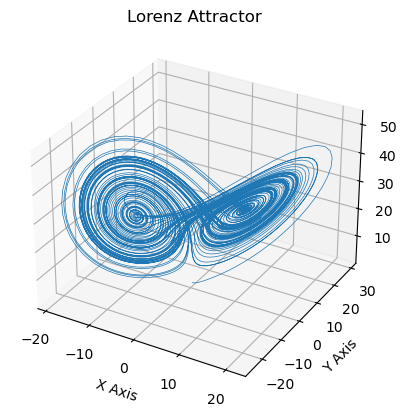

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()


## PROJECTION ONTO Y-COORDINATES

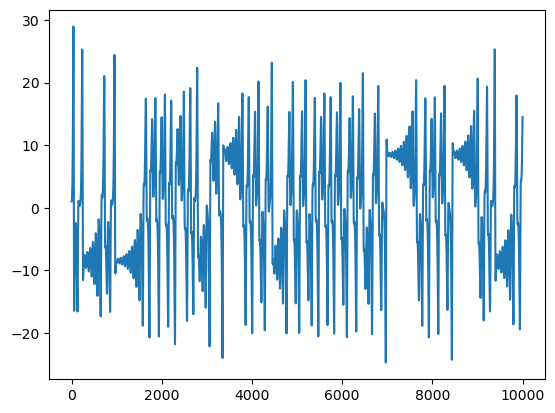

In [7]:
plt.plot(np.arange(xyzs.shape[0]), xyzs[:, 1])
plt.show()

# In his 1981 paper titled "Detecting strange attractors in turbulence", Floris Takens showed that for a generic smooth system $x(t)$ evolving on a smooth $d$-dimensional manifold $\mathcal{M}$, the dynamics of solution can be followed faithfully by taking k time-delayed copies of a generic measurement $h: \mathcal{M} \rightarrow \mathbb{R}$

# $$h(x), h(x(T)), h(x(2T)), \ldots h(x(kT)) $$
# with $k \geq 2d$.

# More formally, he showed that he showed that for such an $h$, the mapping $\mathcal{M} \rightarrow \mathbb{R}^{k+1}$ given by

# $$x \mapsto (h(x), h(x(T)), h(x(2T)), \ldots h(x(kT)))$$
# is a diffeomorphism.

In [2]:
# data wrangling
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import YouTubeVideo
from fastprogress import progress_bar

# hepml
from hepml.core import make_gravitational_waves, download_dataset

# tda magic
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.plotting import plot_heatmap, plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from gtda.time_series import SingleTakensEmbedding

# ml tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

ModuleNotFoundError: No module named 'fastprogress'

In [3]:
embedding_dimension_periodic = 10 #20  #y:10, 3, 5
embedding_time_delay_periodic = 3 #8
stride = 5 #10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

In [4]:
ycoord_embedded = embedder_periodic.fit_transform(xyzs[:, 1])
ycoord_embedded.shape

(1995, 10)

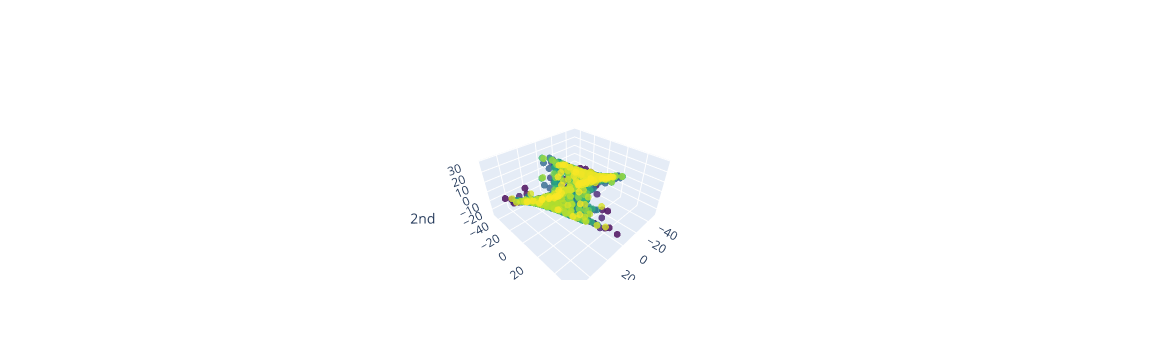

In [5]:
pca = PCA(n_components=3)
ycoord_embedded_pca = pca.fit_transform(ycoord_embedded)

plot_point_cloud(ycoord_embedded_pca)

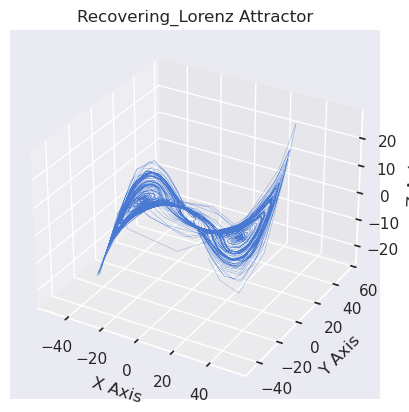

In [17]:
# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*ycoord_embedded_pca.T, lw=0.2)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Recovering_Lorenz Attractor")

plt.show()


## Learning objectives

## References

* [_Sliding Windows and Persistence: An Application of Topological Methods to Signal Analysis_](https://arxiv.org/abs/1307.6188) by J. Perea and J.Harer
* The sliding window notebooks from C. Tralie's [TDALabs](https://github.com/ctralie/TDALabs)
* [_Detection of gravitational waves using topological data analysis and convolutional
neural network: An improved approach_](https://arxiv.org/pdf/1910.08245.pdf) by C. Bresten and J.H.Jung. We thank C. Bresten for sharing the code and data used in the article.

## Why topology for time series?

In time series analysis it is common to represent the signal of interest as a real-valued function over some bounded domain $I$ that represents time:

$$ f: I \to \mathbb{R}$$

One of the most important tasks in time series analysis is the ability to make predictions, e.g. given the Amazon stock price now, what will be the price in one week? One way to tackle this question is to identify _**recurrent**_ patterns in $f$. The goal of this lesson is to show how one can use tools from topological data analysis to answer these type of questions.

Let's see a preview of how this might work. Given a positive real number $\tau$ and a positive integer $M$, the _**sliding window embedding**_ of $f$ with parameters $(M,\tau)$ is the function

$$
SW_{M,\tau} f : \mathbb{R} \to \mathbb{R}^{M+1}\,, \qquad t \to \begin{bmatrix}
           f(t) \\
           f(t + \tau) \\
           f(t + 2\tau) \\
           \vdots \\
           f(t + M\tau)
         \end{bmatrix}
$$

The main idea we will explore in this notebook is that if $f$ has a non-trivial recurrent structure, then the image of $SW_{M,\tau}f$ will have non-trivial topology for appropriate choices of $(M, \tau)$.

## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# uncomment this if running locally or on Google Colab
# !pip install --upgrade hepml

In [2]:
# data wrangling
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import YouTubeVideo
from fastprogress import progress_bar

# hepml
from hepml.core import make_gravitational_waves, download_dataset

# tda magic
from gtda.homology import VietorisRipsPersistence, CubicalPersistence
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.plotting import plot_heatmap, plot_point_cloud, plot_diagram
from gtda.pipeline import Pipeline
from gtda.time_series import TakensEmbedding
from gtda.time_series import SingleTakensEmbedding

# ml tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

## From time series to sliding window embeddings

The first step in analysing the topology of time series is to construct a so-called _**sliding window embedding**_, invented by Takens in the 1960s. As shown in the diagram below, a sliding window embedding of a signal can be thought of as sliding a "window" of fixed size over a signal, with each window represented as a point in a (possibly) higher-dimensional space:

![](https://github.com/lewtun/hepml/blob/master/notebooks/images/sliding_window_embedding.png?raw=1)
<div style="text-align: center">
   <p style="text-align: center;"> <b>Figure reference:</b> https://bit.ly/3easx09 </p>
</div>


More formally: given a time series $f(t)$, one can extract a _**sequence of vectors**_ of the form $f_i = [(f(t_i)), f(t_i + 2 \tau), \ldots, f(t_i + M \tau)] \in \mathbb{R}^{M+1}$, where $M$ is the _**embedding dimension**_ and $\tau$ is the _**time delay**_. The quantity $M\tau$ is known as the "window size" and the difference between $t_{i+1}$ and $t_i$ is called the **_stride_**.

The sliding window allows us to apply Takens' embedding _**locally**_ on a certain interval rather than over the whole time series. The result of this procedure is a _**time series of point clouds**_ with possibly interesting topologies. These topologies can be used to classify whether a signal is periodic or not.

## A periodic example

As a warm-up, recall that a function is periodic with period $T > 0$ if $f(t + T) = f(t)$ for all $t \in \mathbb{R}$. For example, consider the function $f(t) = \cos(5 t)$ which can be visualised as follows:

In [8]:
x_periodic = np.linspace(0, 10, 1000)
y_periodic = np.cos(5 * x_periodic)

print(f"Number of time steps: {len(y_periodic)}")

Number of time steps: 1000


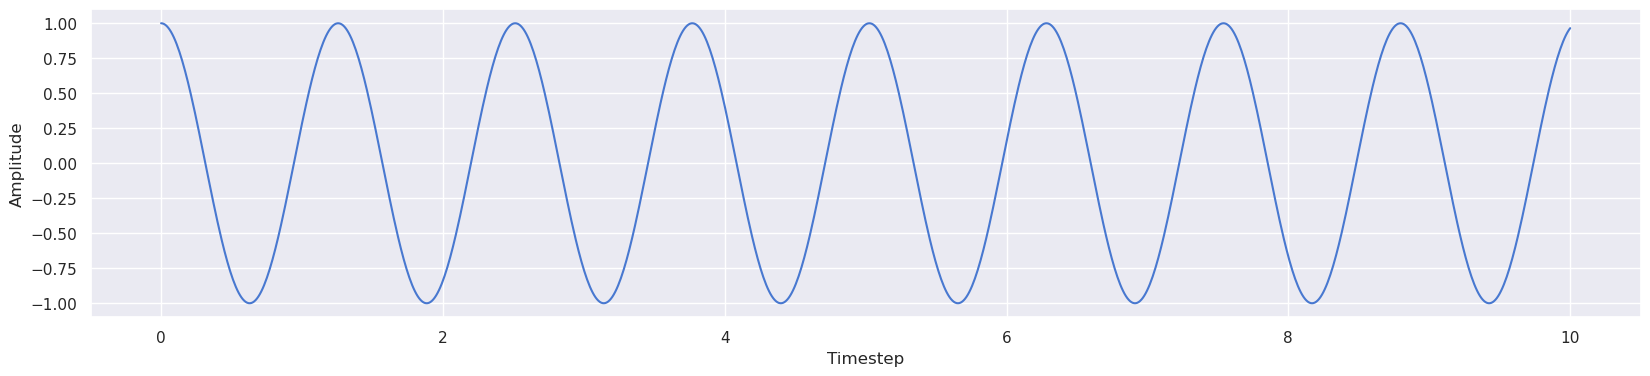

In [9]:
plt.figure(figsize=(20, 4))
plt.plot(x_periodic, y_periodic)
plt.xlabel("Timestep")
plt.ylabel("Amplitude")
plt.show()

We can show that periodicity implies circularity of the sliding window embedding. To do that we need to specify the embedding dimension $M$ and the time delay $\tau$ for the Takens embedding:

In [10]:
embedding_dimension_periodic = 3
embedding_time_delay_periodic = 8
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

> Tip: You can use the `stride` parameter to downsample the sliding window embedding. This is handy when you want to quickly compute persistence diagrams on a dense signal.

Let's apply this embedding to our time series to get a _new_ time series:

In [11]:
y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
y_periodic_embedded.shape

(99, 3)

We have gone from a one-dimensional series to a 3-dimensional one, so let's visualise the sliding window embedding as a point cloud:

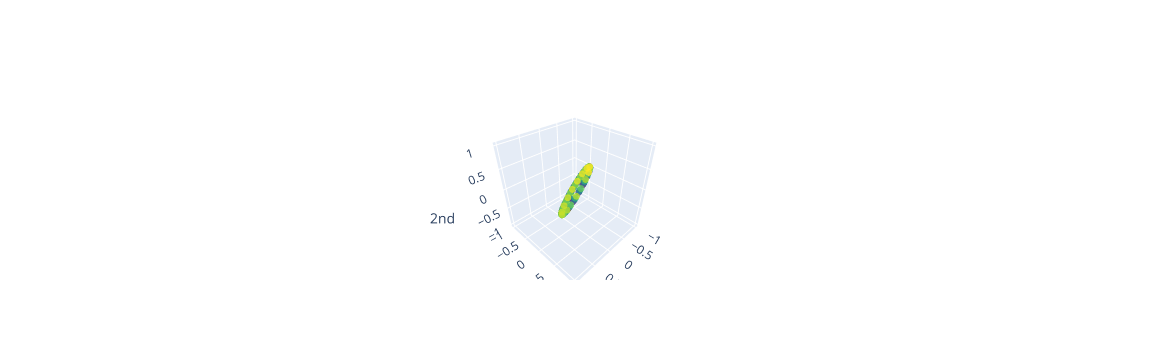

In [12]:
plot_point_cloud(y_periodic_embedded)

As promised, the periodicity of $f$ is reflected in the circularity of the sliding window embedding! It turns out that in general, _**periodic functions trace out ellipses**_ in $\mathbb{R}^{M+1}$.

## A non-periodic example

Here is another type of recurrent behaviour: if we let $f(t) = \cos(t) + \cos(\pi t)$ then it follows that $f$ is not periodic since the ratio of the two frequencies is irrational, i.e. we say that $\cos(t)$ and $\cos(\pi t)$ are _incommensurate_. Nevertheless, their sum produces recurrent behaviour:

In [13]:
x_nonperiodic = np.linspace(0, 50, 1000)
y_nonperiodic = np.cos(x_nonperiodic) + np.cos(np.pi * x_nonperiodic)

print(f"Number of time steps: {len(y_nonperiodic)}")

Number of time steps: 1000


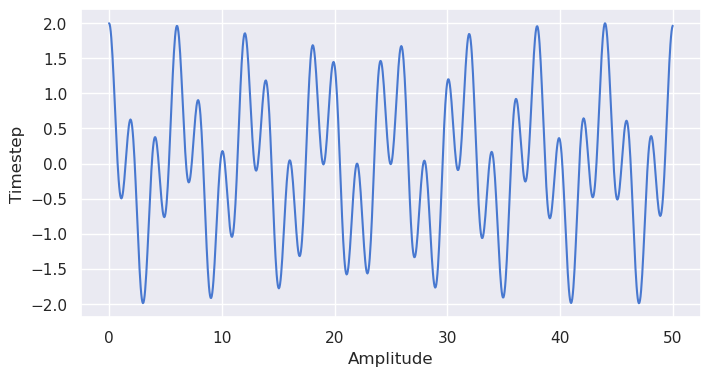

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(x_nonperiodic, y_nonperiodic)
plt.xlabel("Amplitude")
plt.ylabel("Timestep")
plt.show()

As before, let's create a sliding window embedding for this signal and visualise the resulting point cloud:

In [15]:
embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 16
stride = 3

embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=stride,
)

In [16]:
y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y_nonperiodic)
y_nonperiodic_embedded.shape

(323, 3)

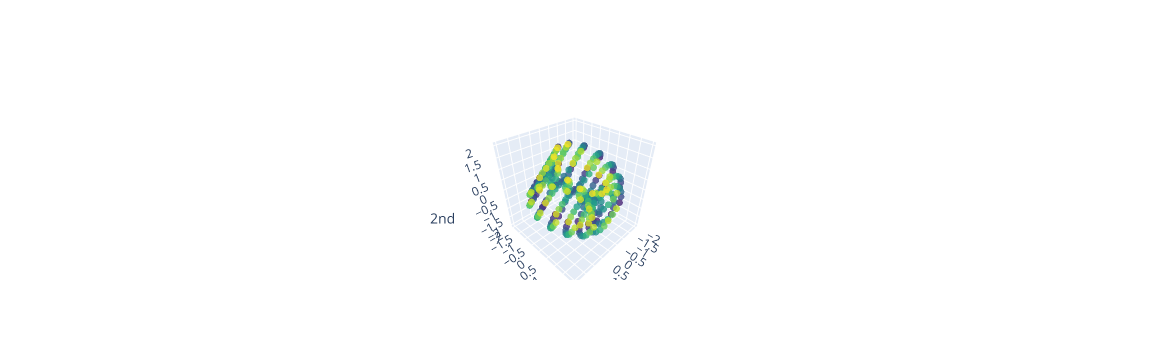

In [17]:
plot_point_cloud(y_nonperiodic_embedded)

### Exercise

How does the window size $M\tau$ affect the geometry of $SW_{M,\tau}f$ for non-periodic functions? Try changing the values above to gain some intuition.

## From sliding window embeddings to persistence diagrams

In the examples above we saw that the resulting point clouds appear to exhibit distinct topology. We can verify this explicitly using persistent homology! First we need to reshape our point cloud arrays in a form suitable for the Vietoris-Rips construction, namely `(n_samples, n_points, n_dimensions)`:

In [18]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

# check shapes
y_periodic_embedded.shape, y_nonperiodic_embedded.shape

((1, 99, 3), (1, 323, 3))

The next step is to calculate the persistence diagrams associated with each point cloud:

In [19]:
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
%time periodic_persistence_diagrams = periodic_persistence.fit_transform(y_periodic_embedded)

CPU times: user 12.8 ms, sys: 32.4 ms, total: 45.2 ms
Wall time: 497 ms


In [20]:
nonperiodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
%time nonperiodic_persistence_diagrams = nonperiodic_persistence.fit_transform(y_nonperiodic_embedded)

CPU times: user 1.92 ms, sys: 1.06 ms, total: 2.98 ms
Wall time: 494 ms


Let's now compare the two diagrams, first for the periodic signal:

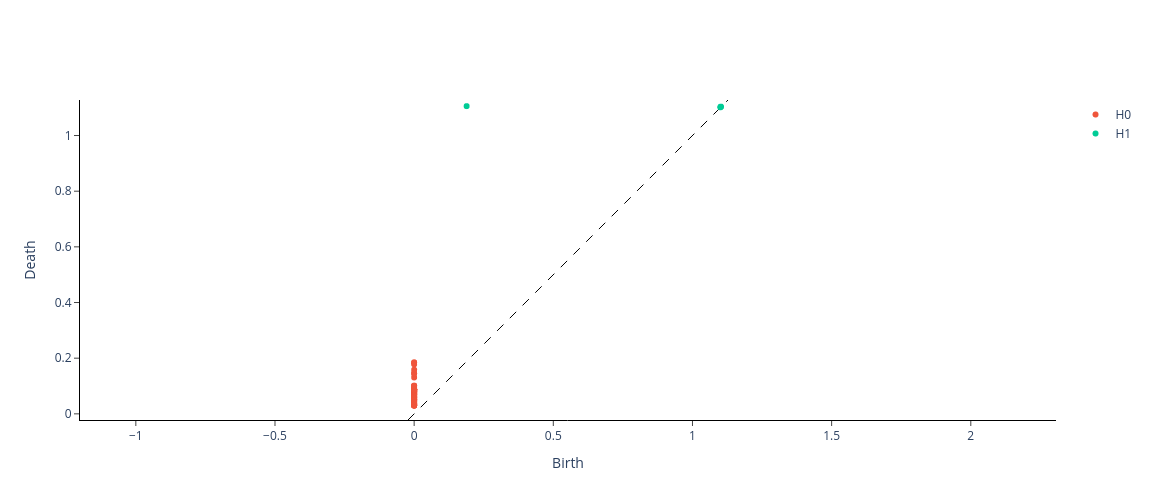

In [21]:
plot_diagram(periodic_persistence_diagrams[0])

from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)and next for the non-periodic one:

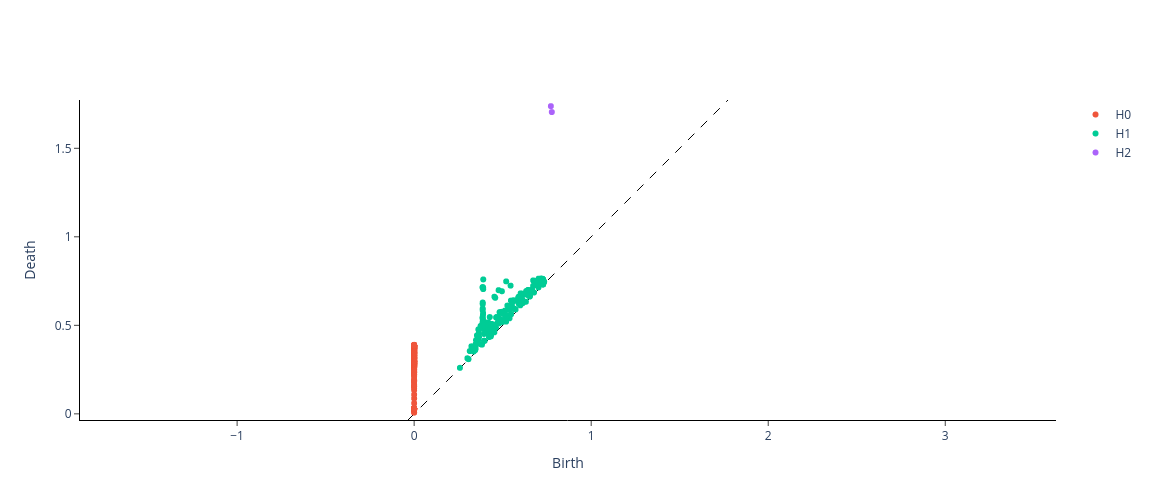

In [22]:
plot_diagram(nonperiodic_persistence_diagrams[0])

What can conclude from these diagrams? The first thing that stands out is the different types of homology dimensions that are most persistent. In the periodic case we see a single point associated with 1-dimensional persistent homology, namely a loop! On the other hand, the non-periodic signal has revealed two points associated with 2-dimensional peristent homology, namely _voids_. These clear differences in topology make the sliding window embedding technique especially powerful at classifying different time series.

## Picking the embedding dimension and time delay

from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)In the examples above, we manually chose values for the embedding dimension $M$ and time delay $\tau$. However, it turns out there are two techniques that can be used to determine these parameters _automatically_:

* [Mutual information](https://en.wikipedia.org/wiki/Mutual_information) to determine $\tau$
* [False nearest neighbours](https://en.wikipedia.org/wiki/False_nearest_neighbor_algorithm) to determine $M$

In giotto-tda, these techniques are applied when we select `parameters_type="search"` in the `TakensEmbedding` transformer, e.g.

```python
embedder = TakensEmbedding(
    parameters_type="search", time_delay=time_delay, dimension=embedding_dimension,
)
```

where the values of `time_delay` and `embedding_dimension` provide _**upper bounds**_ on the search algorithm. Before applying this to our sample signals, let's have a look at how these methods actually work under the hood.

### Mutual information
To determine an optimal value for $\tau$ we first calculate the maximum $x_\mathrm{max}$ and minimum $x_\mathrm{min}$ values of the time series, and divide the interval $[x_\mathrm{min}, x_\mathrm{max}]$ into a large number of bins. We let $p_k$ be the probability that an element of the time series is in the $k$th bin and let $p_{j,k}$ be the probability that $x_i$ is in the $j$th bin while $x_{i+\tau}$ is in the $k$th bin. Then the mutual information is defined as:

$$ I(\tau) = - \sum_{j=1}^{n_\mathrm{bins}} \sum_{k=1}^{n_\mathrm{bins}} p_{j,k}(\tau) \log \frac{p_{j,k}(\tau)}{p_j p_k} $$

The first minimum of $I(\tau)$ gives the optimal delay since there we get the most information by adding $x_{i+\tau}$.

### False nearest neighbours

The false nearest neighbours algorithm is based on the assumption that "unfolding" or embedding a deterministic system into successively higher dimensions is smooth. In other words, points which are close in one embedding dimension should be close in a higher one. More formally, if we have a point $p_i$ and neighbour $p_j$, we check if the normalised distance $R_i$ for the next dimension is greater than some threshold $R_\mathrm{th}$:

$$ R_i = \frac{\mid x_{i+m\tau} - x_{j+m\tau} \mid}{\lVert p_i - p_j \rVert} > R_\mathrm{th}$$

If $R_i > R_\mathrm{th}$ then we have a "false nearest neighbour" and the optimal embedding dimension is obtained by minimising the total number of such neighbours.

### Running the search algorithm

Let's now apply these ideas to our original signals to see what the algorithm determines as optimal choices for $M$ and $\tau$. We will allow the search to scan up to relatively large values of $(M, \tau)$ to ensure we do not get stuck in a sub-optimal minimum.

For the periodic signal, we initialise the Takens embedding as follows:

In [36]:
max_embedding_dimension = 30
max_time_delay = 30
stride = 5

embedder_periodic = SingleTakensEmbedding(
    parameters_type="search", time_delay=max_time_delay, dimension=max_embedding_dimension, stride=stride
)

Let's create a helper function to view the optimal values found during the search:

In [3]:
def fit_embedder(embedder, y, verbose=True):
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}")

    return y_embedded

In [38]:
y_periodic_embedded = fit_embedder(embedder_periodic, y_periodic)

Shape of embedded time series: (171, 6)
Optimal embedding dimension is 6 and time delay is 29


Although the resulting embedding is in a high dimensional space, we can apply [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to project down to 3-dimensions for visualisation:

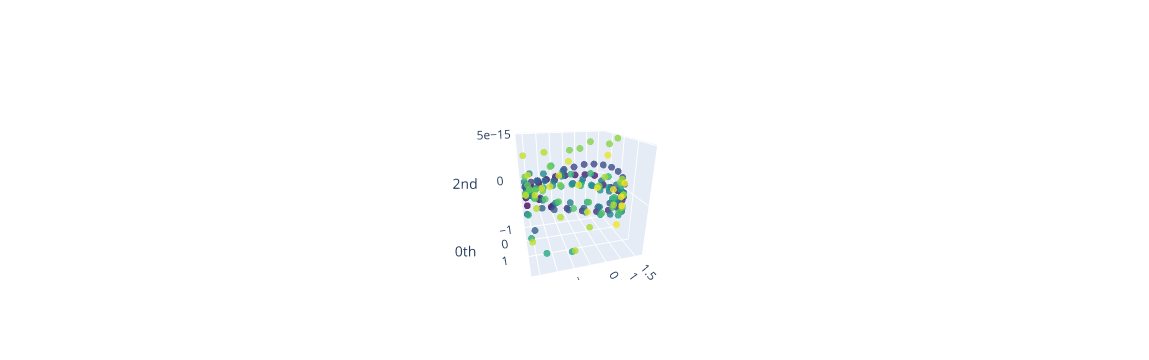

In [39]:
pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)

plot_point_cloud(y_periodic_embedded_pca)

Now for the non-periodic case we have:

In [40]:
embedder_nonperiodic = SingleTakensEmbedding(
    parameters_type="search", n_jobs=2, time_delay=max_time_delay, dimension=max_embedding_dimension, stride=stride,
)

In [41]:
y_nonperiodic_embedded = fit_embedder(embedder_nonperiodic, y_nonperiodic)

Shape of embedded time series: (186, 6)
Optimal embedding dimension is 6 and time delay is 14


As before we can use PCA to project down to 3-dimensions for visualisation:

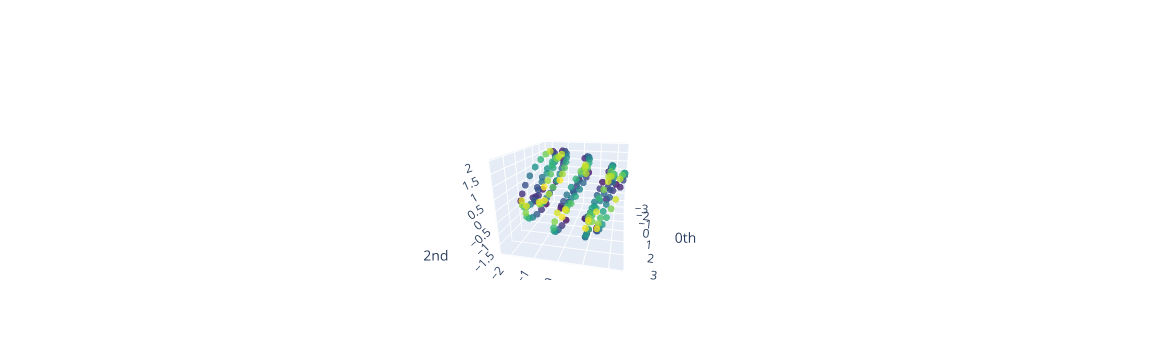

In [42]:
pca = PCA(n_components=3)
y_nonperiodic_embedded_pca = pca.fit_transform(y_nonperiodic_embedded)

plot_point_cloud(y_nonperiodic_embedded_pca)

So we have embedding point clouds whose geometry looks clearly distinct; how about the persistence digrams?

In [43]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

# check shapes
y_periodic_embedded.shape, y_nonperiodic_embedded.shape

((1, 171, 6), (1, 186, 6))

The next step is to calculate the persistence diagrams associated with each point cloud:

In [44]:
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
%time periodic_persistence_diagrams = periodic_persistence.fit_transform(y_periodic_embedded)

CPU times: user 10.5 ms, sys: 29 ms, total: 39.6 ms
Wall time: 584 ms


In [45]:
nonperiodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)

%time nonperiodic_persistence_diagrams = nonperiodic_persistence.fit_transform(y_nonperiodic_embedded)

CPU times: user 2.01 ms, sys: 1.2 ms, total: 3.21 ms
Wall time: 386 ms


Let's now compare the two diagrams, first for the periodic signal:

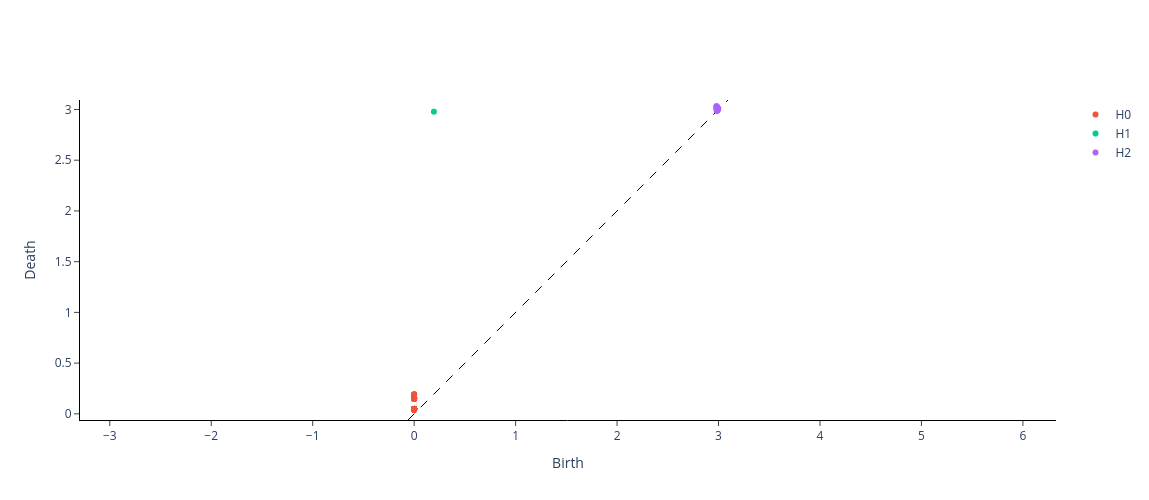

In [46]:
plot_diagram(periodic_persistence_diagrams[0])

and next for the non-periodic one:

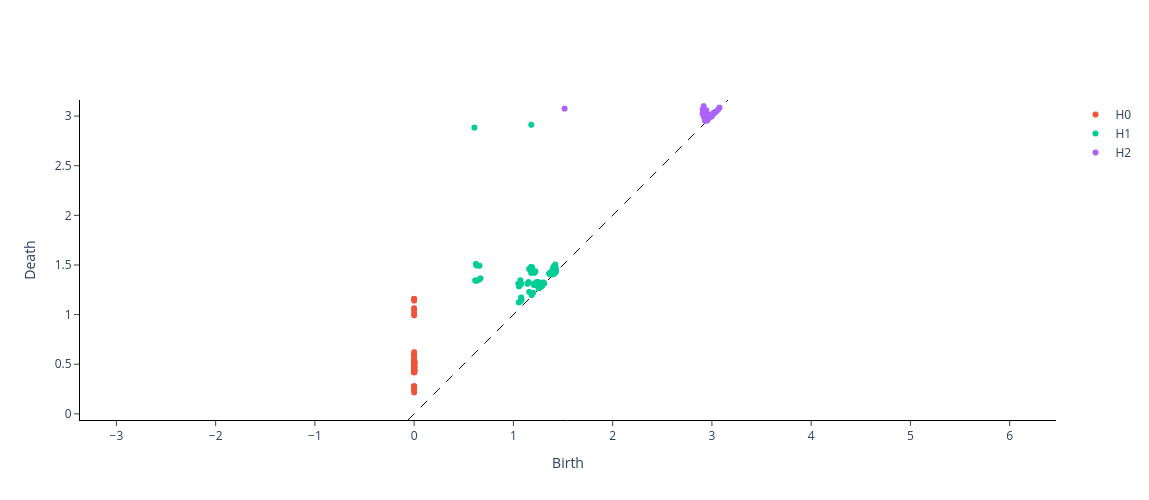

In [47]:
plot_diagram(nonperiodic_persistence_diagrams[0])

In this case the persistence diagram for the periodic signal is essentially unchanged, but the non-periodic signal now reveals two H1 points and one H2 one - the signature of a hypertorus! It turns out that in general, the image of $SW_{M,\tau}f$ is a hypertorus.

### Exercise
Repeat the steps above for the _commensurate_ case, e.g. when $f(t) = \cos(t) + \cos(3t)$. What can you deduce about the resulting persitence diagrams?

## Gravitational wave detection

As an application of the above ideas, let's examine how persistent homology can help detect gravitational waves in noisy signals. The following is adapted from the [article](https://arxiv.org/pdf/1910.08245.pdf) by C. Bresten and J.H. Jung.

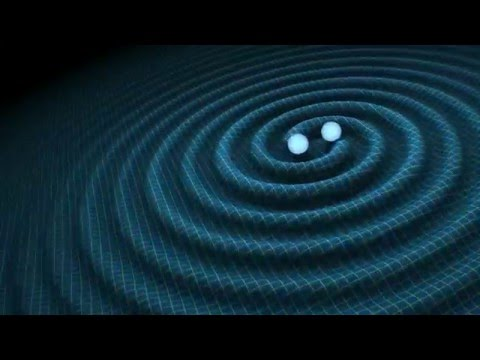

In [18]:
YouTubeVideo("Y3eR49ogsF0", width=600, height=400)

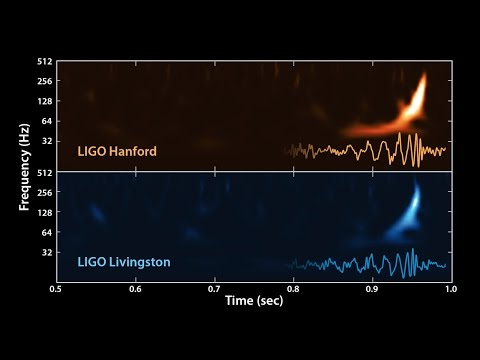

In [19]:
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

In [1]:
import os
os.getcwd()

'/home/evans/Downloads'

### Generate the data

In the article, the authors create a synthetic training set as follows:

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

### Constant signal-to-noise ratio

As a warmup, let's generate some noisy signals with a constant signal-to-noise ratio (SNR) of 17.98. As shown in the table below, this corresponds to an $R$ value of 0.65. By picking the upper end of the interval, we can gain a sense for what is best possible performance for our time series clasifier.

<div style="text-align: center">
<img src='https://github.com/lewtun/hepml/blob/master/notebooks/images/snr-values.png?raw=1'>
</div>

In [9]:
DATA =Path("../data")
download_dataset('gravitational-wave-signals.npy')

NameError: name 'Path' is not defined

In [5]:
R = 0.535
n_signals = 300

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 300
Number of timesteps per series: 8692


In [25]:
noisy_signal_arr = np.asarray(noisy_signals)
noisy_signal_arr.shape

(300, 8692)

In [55]:
grav_signal_arr = np.asarray(gw_signals)
grav_signal_arr.shape

(300, 8192)

array([0., 1., 0., 0., 1.])

In [68]:
noisy_signal_arr[:5, :5]

array([[ 3.11618214e-20,  8.67025977e-20, -5.99860205e-20,
         1.32718747e-19,  6.58731007e-20],
       [ 2.98566041e-19,  1.41340736e-19,  4.40654019e-20,
        -2.77713129e-19,  1.47776888e-19],
       [ 6.84919011e-20, -1.54023803e-19, -3.71947137e-20,
        -1.24933644e-19,  5.85457789e-21],
       [ 1.13517275e-19, -4.21018366e-20,  9.59722080e-21,
         8.59026634e-20,  8.39498530e-21],
       [ 2.18097555e-19,  8.37632313e-20,  6.74430192e-20,
         1.44568864e-19,  8.10151933e-20]])

In [243]:
lab_arr = np.asarray(labels)
np.sum(lab_arr)

149.0

Next let's visualise the two different types of time series that we wish to classify: one that is pure noise vs. one that is composed of noise plus an embedded gravitational wave signal:

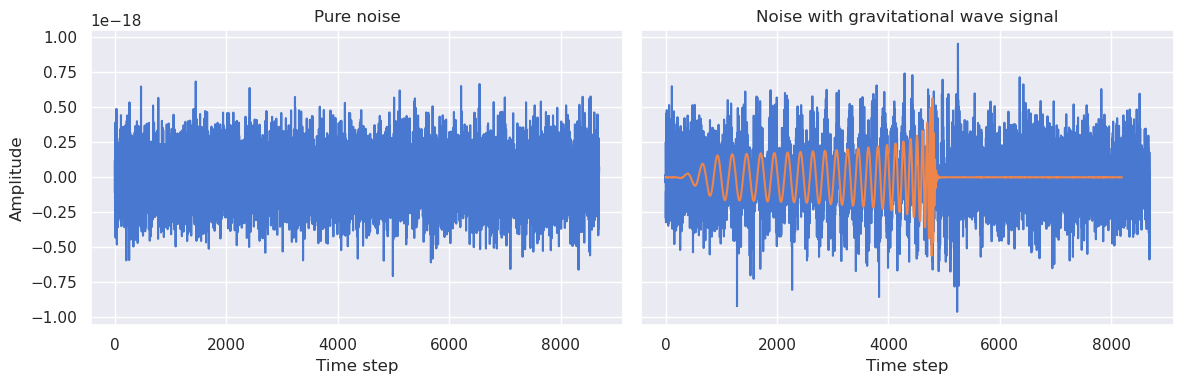

In [6]:
# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

ax0.plot(noisy_signals[background_idx])
ax0.set_ylabel("Amplitude")
ax0.set_xlabel("Time step")
ax0.set_title("Pure noise")

ax1.plot(noisy_signals[signal_idx])
ax1.plot(gw_signals[signal_idx])
ax1.set_xlabel("Time step")
ax1.set_title("Noise with gravitational wave signal")

plt.tight_layout()

Let's examine what the sliding window embedding of a pure gravitational wave signal looks like:

In [15]:
embedding_dimension = 200
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

%time y_gw_embedded = fit_embedder(embedder, gw_signals[0])#gw_signals[0])

Shape of embedded time series: (1529, 20)
Optimal embedding dimension is 20 and time delay is 29
CPU times: user 38.3 ms, sys: 5.11 ms, total: 43.4 ms
Wall time: 337 ms


As we did in our simple examples, we can use PCA to project our high-dimensional space to 3-dimensions for visualisation:

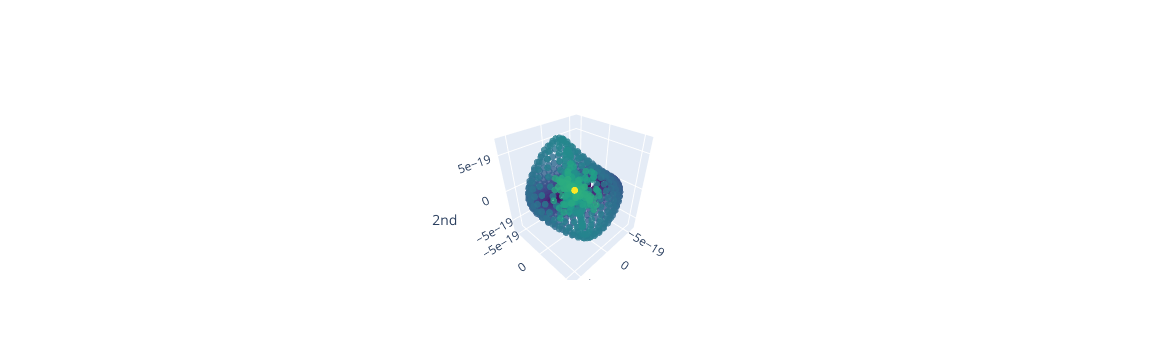

In [16]:
pca = PCA(n_components=3)
y_gw_embedded_pca = pca.fit_transform(y_gw_embedded)

plot_point_cloud(y_gw_embedded_pca)

From the plot we can see that the decaying periodic signal generated by a black hole merger emerges as a spiral in the sliding window embedding space. For contrast, let's compare this to one of the pure noise time series in our sample:

Shape of embedded time series: (1707, 8)
Optimal embedding dimension is 8 and time delay is 23


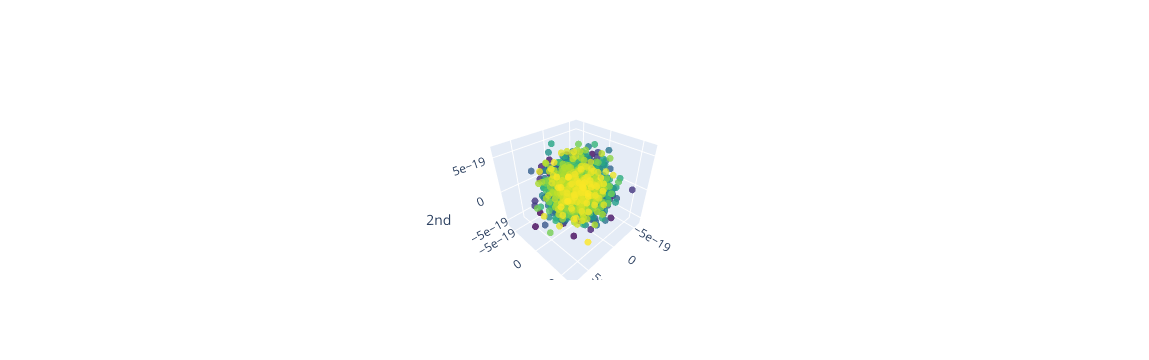

In [19]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = fit_embedder(embedder, noisy_signals[background_idx])

pca = PCA(n_components=3)
y_noise_embedded_pca = pca.fit_transform(y_noise_embedded)

plot_point_cloud(y_noise_embedded_pca)

Evidently pure noise resembles a high-dimensional ball in the sliding window embedding space. Let's see if we can use persistent homology to tease apart which time series contain a gravitational wave signal versus those that don't. To do so we will adapt the strategy from the original article:

1. Generate 200-dimensional sliding window embeddings of each time series
2. Use PCA to reduce the sliding window embeddings to 3-dimensions
3. Use the Vietoris-Rips construction to calculate persistence diagrams of $H_0$ and $H_1$ generators
4. Extract feature vectors using persistence entropy
5. Train a binary classifier on the topological features

### Create sliding window embeddings

We can do steps 1 and 2 in one go with the following code snippet:

In [20]:



embedding_dimension = 200
embedding_time_delay = 10
stride = 10

point_clouds = []

for i in progress_bar(range(len(noisy_signals))):

    embedder = SingleTakensEmbedding(
        parameters_type="fixed", n_jobs=8, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
    )

    pca = PCA(n_components=3)
    point_clouds.append(pca.fit_transform(fit_embedder(embedder, noisy_signals[i], verbose=False)))

point_clouds = np.asarray(point_clouds)
point_clouds.shape

(300, 671, 3)

### Extract topological features

For steps 3 and 4 we can chain the operations using the `Pipeline` class from `giotto-tda`:

In [3]:
homology_dimensions = [0, 1]#,2]

#steps = [
 #   ("persistence", VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)),
  #  ("scaling", Scaler()),
   # ("entropy", PersistenceEntropy()),
#]
#topological_transfomer = Pipeline(steps)
#%time X = topological_transfomer.fit_transform(point_clouds)

persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

diagrams_basic = persistence.fit_transform(point_clouds)

NameError: name 'VietorisRipsPersistence' is not defined

In [22]:
Arr = diagrams_basic[1]
a1=Arr[Arr[:,2]==0].shape[0]; a2=Arr[Arr[:,2]==1].shape[0]#; a3=Arr[Arr[:,2]==2].shape[0] 

Arr_dim_0 = diagrams_basic[:,0:a1,0:2]; Arr_dim_1 = diagrams_basic[:,a1:a1+a2,0:2]#; Arr_dim_2 = diagrams_basic[:,a1+a2:a1+a2+a3,0:2] 

In [23]:
Arr_dim_0.shape

(300, 670, 2)

In [24]:
from teaspoon.ML import feature_functions as Ff
from gtda.diagrams import PersistenceEntropy

In [38]:

persistence_entropy = PersistenceEntropy(normalize=False)

# calculate topological feature matrix
X_features = persistence_entropy.fit_transform(diagrams_basic)

# expect shape - (n_point_clouds, n_homology_dims)
X_features.shape

(300, 2)

In [39]:

FN = 5
my_list = [Arr_dim_0, Arr_dim_1]#, Arr_dim_2]
# compute feature matrix
for i in range(0,2):
    FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(my_list[i], FN)
    X_features = np.concatenate((X_features, FeatureMatrix[-10]),axis=1)
    
    
    
#FN = 5
#FeatureMatrix, TotalNumComb, CombList = Ff.F_CCoordinates(Arr_dim_2, FN)

In [40]:
X_features.shape

(300, 8)

In [41]:
from gtda.diagrams import NumberOfPoints

# Reshape single diagram to (n_samples, n_features, 3) format
#diagram = diagrams_basic[None, :, :]
# Get number of points for (H0, H1, H2)
Arr_pts=NumberOfPoints().fit_transform(diagrams_basic)

In [42]:
Arr_pts.shape

(300, 2)

In [43]:
from gtda.diagrams import Amplitude





metrics = ["bottleneck", "wasserstein", "landscape"]
Arr_amp=Amplitude(metric='bottleneck').fit_transform(diagrams_basic)
for i in range(1,2):
    res = Amplitude(metric=metrics[i]).fit_transform(diagrams_basic)
    Arr_amp = np.concatenate((Arr_amp, res), axis=1)

In [44]:
Arr_amp.shape

(300, 4)

In [45]:
X_features = np.concatenate((X_features, Arr_pts, Arr_amp), axis=1)

In [46]:
X_features.shape

(300, 14)

### Train and evaluate a model

For the final step, let's train a simple classifier on our topological features. As usual we create training and validation sets

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X_features, labels, test_size=0.2, random_state=36)

and then fit and evaluate our model in the same manner as previous lessons:

In [48]:
def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(y_train, fitted_model.predict_proba(X_train)[:, 1]),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(y_valid, fitted_model.predict_proba(X_valid)[:, 1]),
    }
    if hasattr(fitted_model, "oob_score_"):
        res["OOB accuracy:"] = fitted_model.oob_score_

    for k, v in res.items():
        print(k, round(v, 3))

In [49]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
print_scores(rf)

Accuracy on train: 1.0
ROC AUC on train: 1.0
Accuracy on valid: 0.633
ROC AUC on valid: 0.709


In [61]:
y_pred= rf.predict(X_valid)

In [64]:
roc_curve(y_valid, y_pred)
#plt.show()

(array([0.        , 0.44444444, 1.        ]),
 array([0.        , 0.45652174, 1.        ]),
 array([inf,  1.,  0.]))

As a simple baseline this model is not too bad, although it is clearly overfitting the training set. It does better than the deep learning baseline in the article which typically fares little better than random on the raw data. However, the combination of deep learning and persistent homology is where significant performance gains are seen - we leave this as a tantalising hint for what is possible in a future course!

### Exercises

* Perform a hyperparameter search to improve the baseline model above
* In the original article, the authors chose an embedding dimension of 200, followed by PCA reduction to 3-dimensions. Try using the "search" capabilities to find a optimal choice of the embedding dimension and time delay - does this improve the resulting performance?
* Reduce the SNR to a lower value and repeat the above analysis - does the resulting performance match your intuition?
* Instead of using a fixed SNR value, consider sampling 10 SNR values from the range of the original article $R \in (0.075, 0.65)$. Repeat the above steps and see whether you can build a model that does better than random (this is tricky!)

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys

In [59]:
spf = wave.open("/home/olakunle/Downloads/tda_class/Project/health_audio/Project_3/Wheezing/BP12_Asthma,E W,P L L,50,F.wav", "r")

In [17]:
#spf = wave.open("/home/olakunle/.cache/kagglehub/datasets/warcoder/cats-vs-dogs-vs-birds-audio-classification/versions/1/Animals/bird/24c9f572_nohash_1.wav", "r")

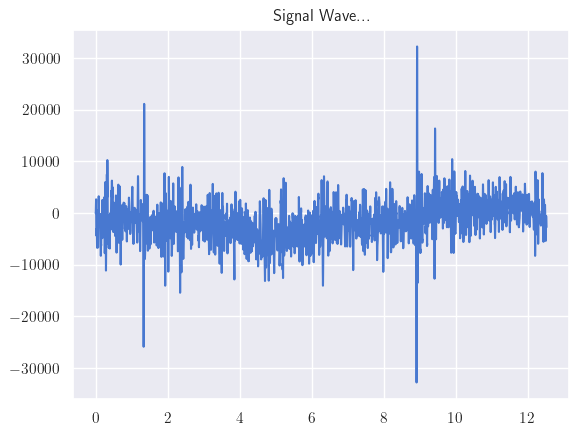

In [60]:
# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.frombuffer(signal, np.int16)
fs = spf.getframerate()

# If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)


Time = np.linspace(0, len(signal) / fs, num=len(signal))

plt.figure(1)
plt.title("Signal Wave...")
plt.plot(Time, signal)
#plt.savefig("/home/olakunle/Downloads/tda_class/bird_n.jpg")
plt.show()